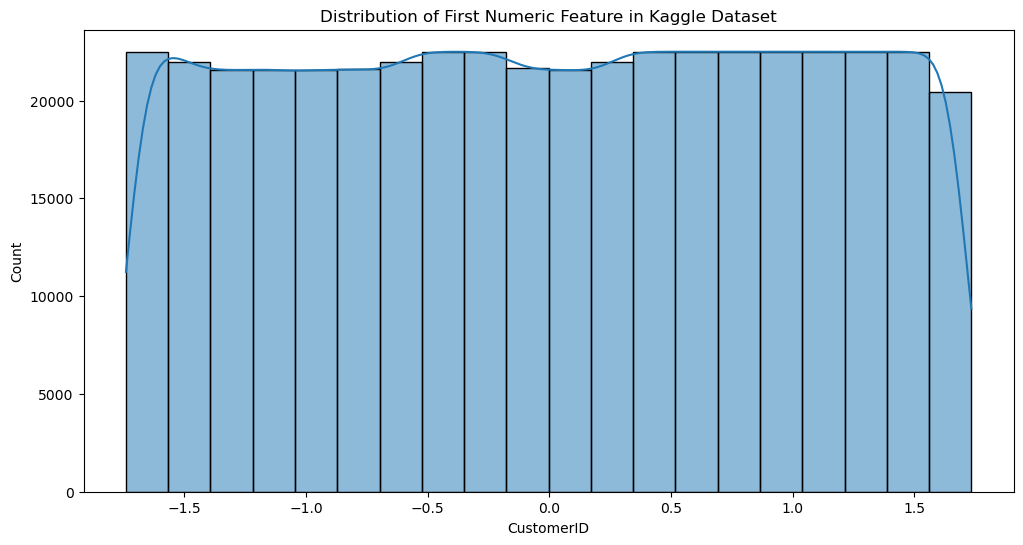

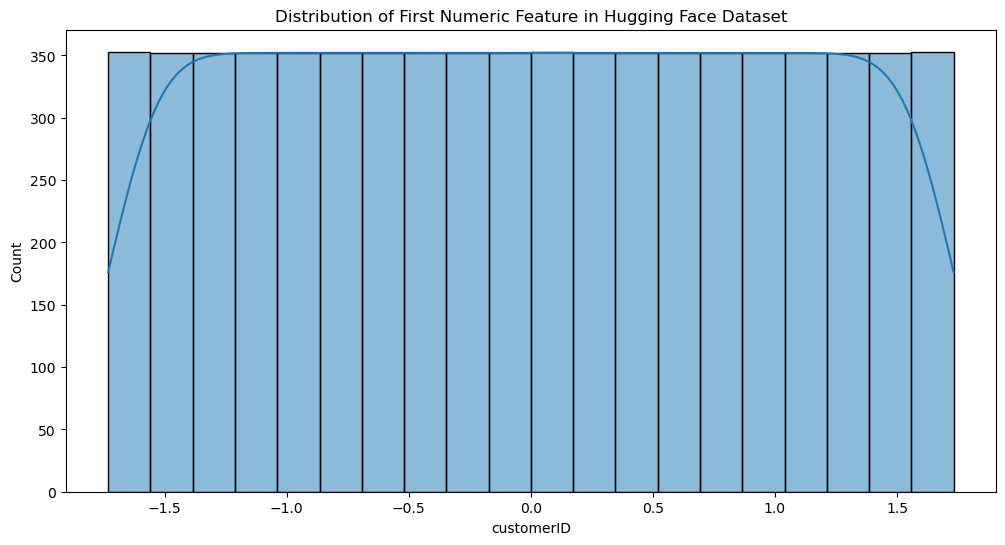

In [3]:
import os
import pandas as pd
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Configure logging
LOGS_PATH = "logs/"
os.makedirs(LOGS_PATH, exist_ok=True)
logging.basicConfig(filename=os.path.join(LOGS_PATH, 'data_preparation.log'), level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Define paths
LOCAL_STORAGE_PATH = "raw_data/"
PROCESSED_DATA_PATH = "processed_data/"
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
LATEST_DATE = datetime.now().strftime('%Y-%m-%d')
KAGGLE_DATA_PATH = os.path.join(LOCAL_STORAGE_PATH, "kaggle", LATEST_DATE, "kaggle_churn.csv")
HUGGINGFACE_DATA_PATH = os.path.join(LOCAL_STORAGE_PATH, "huggingface", LATEST_DATE, "huggingface_churn.csv")

# Load datasets
def load_data(file_path, source):
    if not os.path.exists(file_path):
        logging.error(f"{source} dataset not found at {file_path}")
        return None
    df = pd.read_csv(file_path)
    logging.info(f"Loaded {source} dataset with {df.shape[0]} rows and {df.shape[1]} columns.")
    return df

# Handle missing values
def handle_missing_values(df):
    df.fillna(df.median(numeric_only=True), inplace=True)  # Impute numerical columns with median
    df.fillna("Unknown", inplace=True)  # Fill categorical missing values with 'Unknown'
    return df

# Encode categorical variables
def encode_categorical(df):
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    return df

# Normalize numerical features
def normalize_numerical(df):
    scaler = StandardScaler()
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df

# Generate basic EDA visuals
def generate_eda_plots(df, source):
    plt.figure(figsize=(12, 6))
    sns.histplot(df.iloc[:, 0], bins=20, kde=True)
    plt.title(f"Distribution of First Numeric Feature in {source} Dataset")
    plt.show()

if __name__ == "__main__":
    kaggle_df = load_data(KAGGLE_DATA_PATH, "Kaggle")
    hf_df = load_data(HUGGINGFACE_DATA_PATH, "Hugging Face")
    
    for source, df in zip(["Kaggle", "Hugging Face"], [kaggle_df, hf_df]):
        if df is not None:
            df = handle_missing_values(df)
            df = encode_categorical(df)
            df = normalize_numerical(df)
            generate_eda_plots(df, source)
            processed_path = os.path.join(PROCESSED_DATA_PATH, f"{source}_cleaned.csv")
            df.to_csv(processed_path, index=False)
            logging.info(f"Cleaned data saved at {processed_path}")
    
    logging.info("Data preparation completed.")
